# pyStan

Model to implement:
1. Categorical Logistic Regression
2. Bayesian Linear Regression
2. Single Subject Bayesian RL
3. Hierarchical RL

----
```
author:    Zach Wolpe
email:     zach.wolpe@medibio.com.au
date:      14 January 2022
```


In [ ]:
import matplotlib.pyplot as plt
import theano.tensor as tt
from scipy import stats
from tqdm import tqdm
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import pystan
import theano
import math

# 1. Categorical Logistic Regression

In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
# define dataset
X, y = make_classification(n_samples=1000, n_features=10, n_informative=5, n_redundant=5, n_classes=3, random_state=1)
# define the multinomial logistic regression model
model = LogisticRegression(multi_class='multinomial', solver='lbfgs')
# define the model evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate the model and collect the scores
n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
# report the model performance
print('Mean Accuracy: %.3f (%.3f)' % (mean(n_scores), std(n_scores)))



Mean Accuracy: 0.681 (0.042)


# Categorical Model

In [ ]:

stan_data = {
    'n_t': X.shape[0],
    'D': X.shape[1],
    'K': 3,
    'x': X,
    'y': y + 1
}


In [ ]:
stan_model = """
  data {
    int<lower=1> n_t;     // samples
    int D;                // covariates  
    int K;                // outcomes = 3
    int y[n_t];
    matrix[n_t, D] x;
  }

  parameters {
    matrix[D, K] beta;
  }

  model {
    matrix[n_t, K] x_beta = x * beta;

    to_vector(beta) ~ normal(0, 5);


    for (i in 1:n_t) {
      y[i] ~ categorical_logit(x_beta[i,]');
    }
  }
"""

fit = pystan.stan(model_code=stan_model, data=stan_data, iter=200, chains=1)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_403ae15c39b76ec1201b94ddee9da0e9 NOW.


KeyboardInterrupt: ignored

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f8e31000990>,
      dtype=object)

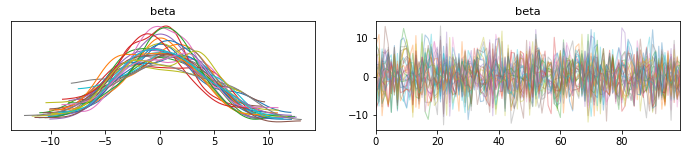

In [ ]:
az.plot_trace(fit)

# Hierachical Regression =====================================

- [Stan](https://mc-stan.org/docs/2_28/stan-users-guide/hierarchical-logistic-regression.html)
- [data (pyMC3)](https://docs.pymc.io/en/v3/pymc-examples/examples/case_studies/multilevel_modeling.html)

- [pyStan example](https://mc-stan.org/users/documentation/case-studies/radon.html)



In [ ]:
srrs2                 = pd.read_csv(pm.get_data("srrs2.dat"))
srrs2.columns         = srrs2.columns.map(str.strip)
srrs_mn               = srrs2[srrs2.state == "MN"].copy()
srrs_mn["fips"]       = srrs_mn.stfips * 1000 + srrs_mn.cntyfips
cty                   = pd.read_csv(pm.get_data("cty.dat"))
cty_mn                = cty[cty.st == "MN"].copy()
cty_mn["fips"]        = 1000 * cty_mn.stfips + cty_mn.ctfips
srrs_mn               = srrs_mn.merge(cty_mn[["fips", "Uppm"]], on="fips")
srrs_mn               = srrs_mn.drop_duplicates(subset="idnum")
u                     = np.log(srrs_mn.Uppm).unique()
n                     = len(srrs_mn)
srrs_mn.county        = srrs_mn.county.map(str.strip)
mn_counties           = srrs_mn.county.unique()
counties              = len(mn_counties)
county_lookup         = dict(zip(mn_counties, range(counties)))
county                = srrs_mn["county_code"] = srrs_mn.county.replace(county_lookup).values
radon                 = srrs_mn.activity
srrs_mn["log_radon"]  = log_radon = np.log(radon + 0.1).values
floor                 = srrs_mn.floor.values

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [ ]:
data = pd.DataFrame({'log_radon':log_radon, 'county':county + 1, 'floor':floor + 1})
data.head(2)


,log_radon,county,floor
0,0.832909,1,2
1,0.832909,1,1


# Reinforcement Learning ==========================================

In [ ]:

# DGP ----------------------------------------------------------------------*
def data_generating_process(alpha, beta, n=100, p_r=[.8, .6, .7]):
  actions = np.zeros(n, dtype=np.int)
  rewards = np.zeros(n, dtype=np.int)
  Qs      = np.zeros((n, 3))

  # Q init
  Q = np.array(len(p_r)*[1/len(p_r)])

  for i in tqdm(range(n)):
    # P(a|Q): Apply Boltzmann distribution
    exp_Q = np.exp(beta*Q)
    pi_a  = exp_Q / np.sum(exp_Q)


    # Simulate action-reward
    a = np.random.choice([0,1,2], p=pi_a)
    r = np.random.rand() < p_r[a]

    # Update Qt(a) = Qt-1(a) + a[RPE]
    Q[a] = Q[a] + alpha * (r - Q[a])

    # store
    actions[i] = a
    rewards[i] = r
    Qs[i] = Q.copy()

  return actions, rewards, Qs  

In [ ]:
# DGP
true_alpha  = 0.8
true_beta   = 2
n           = 100
actions, rewards, Qs = data_generating_process(alpha=true_alpha, beta=true_beta, n=n)

100%|██████████| 100/100 [00:00<00:00, 9947.83it/s]


In [ ]:
# Stan Model: Reinforcement Learning
data_object = {
    'n_t':      n,
    'action':  actions+1,
    'reward':  rewards+1,
}

In [ ]:
stan_data = """
  data {
    int  n_t;
    int action[n_t];
    int reward[n_t];
  }
"""

stan_parameters = """
  parameters {
    real<lower=0, upper=1> a;
    real b; 
  }

  

"""


stan_model = """
  model {
    matrix[n_t, 3] Qs;
    matrix[n_t, 3] BQs;

    // matrix[n_t, 3] pi;

    for (i in 1:n_t) {
        if (i == 1) {
          for (v in 1:3) {
            Qs[i, v]  = 0.3333;
            BQs[i, v] = b * Qs[i, v]; 
          }
        }
        if (i > 1) {
          for (v in 1:3) {
            Qs[i, v] = Qs[i-1, v];
            BQs[i,v] = BQs[i-1,v];
            }
          Qs[i, action[i]]  = Qs[i-1, action[i]] + a * (reward[i]-1 - Qs[i-1, action[i]]);
          BQs[i, action[i]] = b * Qs[i, action[i]];
        }
        }


    // prior
    //a ~ beta(1,1);
    //b ~ normal(0, 10);
    
    for (t in 1:n_t) {
      action[t] ~ categorical_logit(BQs[t]');
      }
  }
"""

model = stan_data + stan_parameters + stan_model
fit   = pystan.stan(model_code=model, warmup=1000, data=data_object, iter=2000, chains=4)


In [ ]:
# ?pystan.stan

In [ ]:
print(fit)

Inference for Stan model: anon_model_689d9fa8187bc9b7ccca254f1ffeeebf.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a      0.78  3.2e-3   0.12   0.52   0.69   0.78   0.87   0.98   1475    1.0
b      2.25    0.01    0.5    1.4   1.89   2.21   2.53   3.39   1241    1.0
lp__ -91.33    0.03   1.09 -94.16 -91.77 -90.99 -90.54 -90.25   1032    1.0

Samples were drawn using NUTS at Mon Jan 17 11:38:29 2022.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


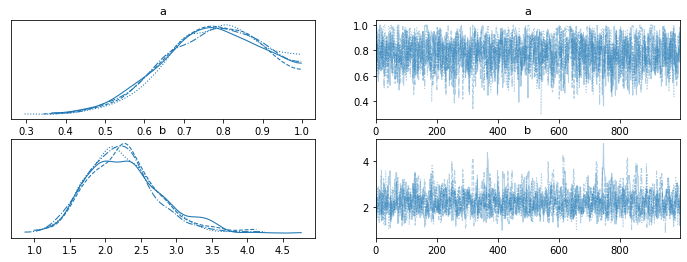

In [ ]:
az.plot_trace(fit);

# Hierarchical Reinforcement Learning =========================================


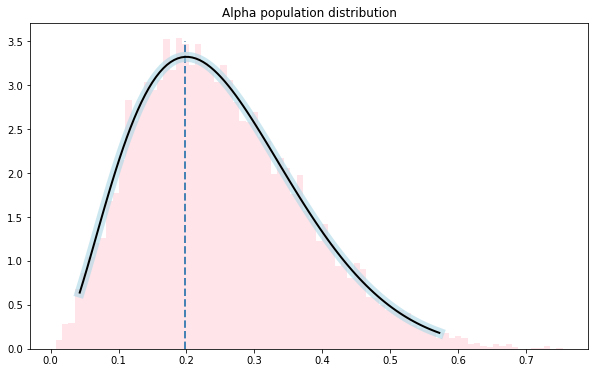

In [ ]:
# alpha population distribution ------------------------------*
# params
a,b = 3,9

# distribution
mean, var, skew, kurt = stats.beta.stats(a,b, moments='mvsk')
x = np.linspace(stats.beta.ppf(0.01, a, b),
                stats.beta.ppf(0.99, a, b), 100)
y = stats.beta.pdf(x, a, b)

# random sample
rv = stats.beta(a, b)
r  = rv.rvs(size=10000)

# vis 
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(x, y, 'lightblue', lw=10, alpha=0.6, label='beta pdf')
ax.plot(x, y, 'k-', lw=2, label='frozen pdf')
ax.hist(r, bins=80, density=True, color='pink', histtype='stepfilled', alpha=0.4)
ax.vlines(x=x[np.where(y==max(y))], ymin=0, ymax=3.5, lw=2, color='steelblue', linestyles='dashed')
plt.title('Alpha population distribution')
plt.show()
# alpha population distribution ------------------------------*

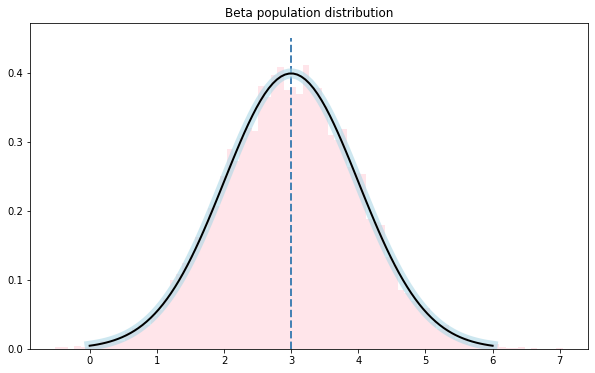

In [ ]:
# beta population distribution -------------------------------*
# params
mu        = 3
variance  = 1

# distribution
sigma = math.sqrt(variance)
x     = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y     = stats.norm.pdf(x, mu, sigma)

# random sample
rv = stats.norm(mu, sigma)
r  = rv.rvs(size=10000)

# vis 
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(x, y, 'lightblue', lw=10, alpha=0.6, label='alpha pdf')
ax.plot(x, y, 'k-', lw=2, label='frozen pdf')
ax.hist(r, bins=80, density=True, color='pink', histtype='stepfilled', alpha=0.4)
ax.vlines(x=mu, ymin=0, ymax=0.45, lw=2, color='steelblue', linestyles='dashed')
plt.title('Beta population distribution')
plt.show()
# beta population distribution -------------------------------*

In [ ]:
# sample population distributions ------------------------------------------*
n_samples = 100
subject_betas  = stats.norm(loc=mu, scale=sigma).rvs(n_samples)
subject_alphas = stats.beta(a, b).rvs(n_samples)

In [ ]:
# a_mu, a_sig = 0.2, 0.05
# b_mu, b_sig = 2, 1
# n_samples   = 100
# subject_alphas =  stats.norm(loc=a_mu, scale=a_sig).rvs(n_samples)
# subject_betas  =  stats.norm(loc=b_mu, scale=b_sig).rvs(n_samples)

In [ ]:
# store as a dict
n = 100
data = {}
for i, theta in enumerate(zip(subject_alphas, subject_betas)):
  actions, rewards, Qs = data_generating_process(alpha=theta[0], beta=theta[1], n=n)
  data['subject_'+str(i)] = {'actions': actions, 'rewards':rewards, 'true_alpha':theta[0], 'true_beta':theta[1], 'Qs':Qs}

In [ ]:
# Convert to table data structure -------------*
%%time
if 'df' in globals(): del df

for subject in tqdm(data.keys()):
  if 'df' not in globals():
    df = pd.DataFrame({
        'subject' : [subject] * n_samples, 
        'actions' : data[subject]['actions'],
        'rewards' : data[subject]['rewards'],
        'true_alpha' : data[subject]['true_alpha'], #* n_samples,
        'true_beta' : data[subject]['true_beta'] #* n_samples
        })
  else:
    df2 = pd.DataFrame({
        'subject' : [subject] * n_samples, 
        'actions' : data[subject]['actions'],
        'rewards' : data[subject]['rewards'],
        'true_alpha' : data[subject]['true_alpha'], #* n_samples,
        'true_beta' : data[subject]['true_beta'] #* n_samples
        })
    df = df.append(df2, ignore_index=False)
df['subject_idx'] = [int(i.split('_')[1]) for i in df.subject]

100%|██████████| 100/100 [00:00<00:00, 661.47it/s]

CPU times: user 155 ms, sys: 4.23 ms, total: 159 ms
Wall time: 168 ms


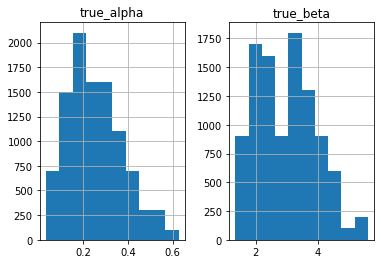

In [ ]:
df.hist(['true_alpha', 'true_beta']);

In [ ]:
# transform data
action_matrix = df.reset_index()[['index', 'subject', 'actions']].pivot(index=['subject'], columns='index')
reward_matrix = df.reset_index()[['index', 'subject', 'rewards']].pivot(index=['subject'], columns='index')
data_ = {
    'n_s':    reward_matrix.shape[0],
    'n_t':    reward_matrix.shape[1],
    'action': action_matrix+1,
    'reward': reward_matrix+1
}

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


In [ ]:
import pystan

In [ ]:
model = """

data {
  int<lower=1> n_s;
  int<lower=1> n_t;
  int action[n_s, n_t];     
  int reward[n_s, n_t]; 
}

transformed data {
  vector[3] initQs;  // initial values for V
  initQs = rep_vector(0.3333, 3);
}

parameters {
  real<lower=0,upper=1> a_mu;
  real<lower=0,upper=10> b_mu;

  real<lower=0> a_sd;
  real<lower=0> b_sd;

  real<lower=0,upper=1> a[n_s];
  real<lower=0,upper=10> b[n_s];  
}

model {
  // individual variance priors! 
  a_sd  ~ cauchy(0,3);
  b_sd ~ cauchy(0,8);
  
  // give the prior here: how individual-level parameters are connected to the group-level parameters
  a ~ normal(a_mu, a_sd);
  b ~ normal(b_mu, b_sd);
  
  
  for (s in 1:n_s) {
    vector[3] Qs; 
    real pe;    
    Qs = initQs;

    for (t in 1:n_t) {        
      action[s,t] ~ categorical_logit( b[s] * Qs);
      pe = reward[s,t] - Qs[action[s,t]];      
      Qs[action[s,t]] = Qs[action[s,t]] + a[s] * pe; 
    }
  }    
}


"""

fit   = pystan.stan(model_code=model, warmup=1000, data=data_, iter=2000, chains=2)


INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8067b1363a0392582972f1830dd500bb NOW.


In [ ]:
print(fit)

Inference for Stan model: anon_model_8067b1363a0392582972f1830dd500bb.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a_mu     0.33  6.1e-4   0.02   0.29   0.32   0.33   0.34   0.37   1170    1.0
b_mu     1.92  2.5e-3   0.09   1.75   1.86   1.92   1.98    2.1   1224    1.0
a_sd     0.16  5.7e-4   0.02   0.13   0.15   0.16   0.17   0.19    850    1.0
b_sd     0.71  3.4e-3   0.08   0.56   0.66   0.71   0.76   0.88    570    1.0
a[1]     0.17  2.0e-3   0.09   0.03    0.1   0.16   0.23   0.38   2070    1.0
a[2]     0.35  1.3e-3   0.07   0.23   0.31   0.35    0.4    0.5   2584    1.0
a[3]      0.2  1.1e-3   0.05    0.1   0.16   0.19   0.23   0.31   2586    1.0
a[4]     0.31  1.2e-3   0.06   0.19   0.26    0.3   0.35   0.43   2558    1.0
a[5]     0.39  1.2e-3   0.06   0.27   0.34   0.38   0.43   0.52   2912    1.0
a[6]     0.38  2.0e-3   0.09   

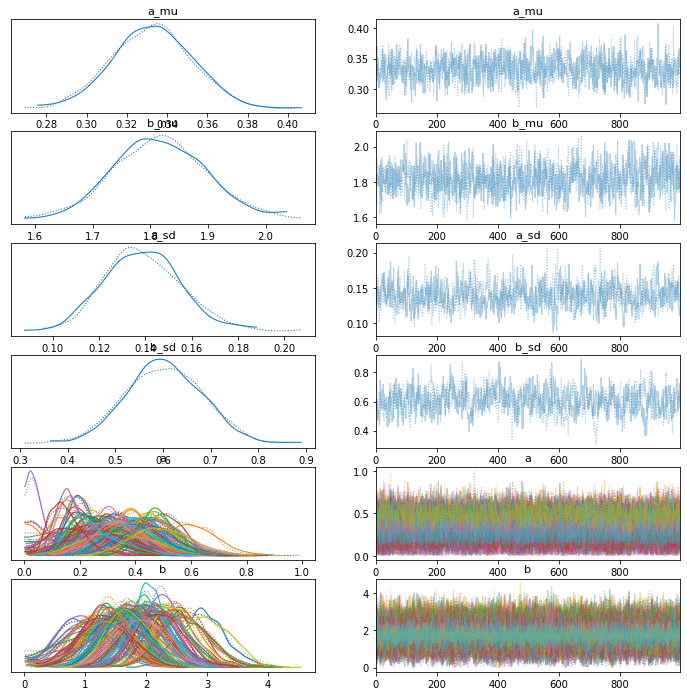

In [ ]:
az.plot_trace(fit);

In [ ]:
import plotly.express as px
print('Alpha: ', np.mean(fit['a_mu']))
px.histogram(x=fit['a_mu'], template='none')

print('beta: ', np.mean(fit['b_mu']))
px.histogram(x=fit['b_mu'], template='none')


Alpha:  0.33276279986278096
beta:  1.8167410208023966


In [ ]:
a_al_true, b_al_true, loc_al_true, scale_al_true = stats.beta.fit(df.true_alpha, floc=0, fscale=1)
a_al_aprx, b_al_aprx, loc_al_aprx, scale_al_aprx = stats.beta.fit(fit['a_mu'], floc=0, fscale=1)
# a_al_aprx, b_al_aprx, loc_al_aprx, scale_al_aprx = stats.beta.fit(df.true_beta, floc=0, fscale=1)

# # https://stats.stackexchange.com/questions/68983/beta-distribution-fitting-in-scipy
# a_al_true, b_al_true, loc_al_true, scale_al_true = stats.beta.fit(true_alphas, floc=0, fscale=1)
# a_al_aprx, b_al_aprx, loc_al_aprx, scale_al_aprx = stats.beta.fit(approx_alpha, floc=0, fscale=1)

beta_true_mu, beta_true_std = stats.norm.fit(df.true_beta)
beta_aprx_mu, beta_aprx_std = stats.norm.fit(fit['b_mu'])


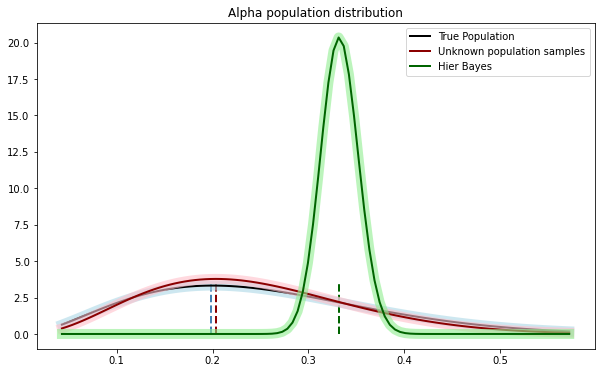

In [ ]:
# alpha population distribution ------------------------------*
# params
a,b = 3,9

# distribution
mean, var, skew, kurt = stats.beta.stats(a,b, moments='mvsk')
x = np.linspace(stats.beta.ppf(0.01, a, b),
                stats.beta.ppf(0.99, a, b), 100)
y = stats.beta.pdf(x, a, b)

# random sample
rv = stats.beta(a, b)
r  = rv.rvs(size=10000)

# vis 
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(x, y, 'lightblue', lw=10, alpha=0.6)
ax.plot(x, y, 'k-', lw=2, label='True Population')
ax.vlines(x=x[np.where(y==max(y))], ymin=0, ymax=3.5, lw=2, color='steelblue', linestyles='dashed')

# fit (unknown) true sample values
rv_alpha_true = stats.beta(a=a_al_true, b=b_al_true, loc=loc_al_true, scale=scale_al_true).pdf(x)
ax.plot(x, rv_alpha_true, 'pink', lw=10, alpha=0.6)
ax.plot(x, rv_alpha_true, 'k-', lw=2, color='darkred', label='Unknown population samples')
ax.vlines(x=x[np.where(rv_alpha_true==max(rv_alpha_true))], ymin=0, ymax=3.5, lw=2, color='darkred', linestyles='dashed')

# fit approx values 
rv_alpha_aprx = stats.beta(a_al_aprx, b_al_aprx, loc_al_aprx, scale_al_aprx).pdf(x)
ax.plot(x, rv_alpha_aprx, 'lightgreen', lw=10, alpha=0.6)
ax.plot(x, rv_alpha_aprx, 'k-', lw=2, color='darkgreen', label='Hier Bayes')
ax.vlines(x=x[np.where(rv_alpha_aprx==max(rv_alpha_aprx))], ymin=0, ymax=3.5, lw=2, color='darkgreen', linestyles='dashed')


plt.title('Alpha population distribution')
plt.legend()
plt.show()
# alpha population distribution ------------------------------*

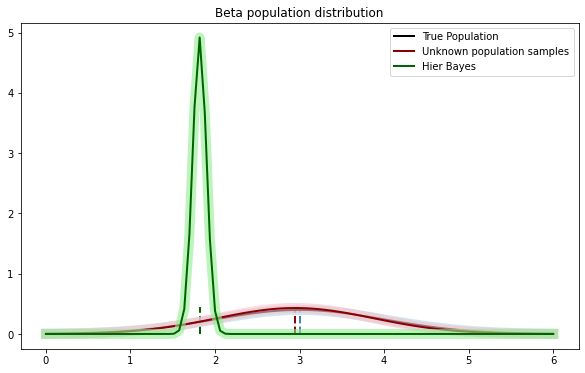

In [ ]:
# beta population distribution -------------------------------*
# params
mu        = 3
variance  = 1

# distribution
sigma = math.sqrt(variance)
x     = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
y     = stats.norm.pdf(x, mu, sigma)

# random sample
# rv = stats.norm(mu, sigma)
# r  = rv.rvs(size=10000)

# vis 
fig, ax = plt.subplots(1, 1, figsize=(10,6))
ax.plot(x, y, 'lightblue', lw=10, alpha=0.6)
ax.plot(x, y, 'k-', lw=2, label='True Population')
# ax.hist(r, bins=80, density=True, color='pink', histtype='stepfilled', alpha=0.4)
ax.vlines(x=mu, ymin=0, ymax=0.45, lw=2, color='steelblue', linestyles='dashed')


# fit (unknown) true sample values
rv_beta_true = stats.norm(beta_true_mu, beta_true_std).pdf(x)
ax.plot(x, rv_beta_true, 'pink', lw=10, alpha=0.6)
ax.plot(x, rv_beta_true, 'k-', lw=2, color='darkred', label='Unknown population samples')
ax.vlines(x=beta_true_mu, ymin=0, ymax=0.45, lw=2, color='darkred', linestyles='dashed')

# fit approx values 
rv_beta_apprx = stats.norm(beta_aprx_mu, beta_aprx_std).pdf(x)
ax.plot(x, rv_beta_apprx, 'lightgreen', lw=10, alpha=0.6)
ax.plot(x, rv_beta_apprx, 'k-', lw=2, color='darkgreen', label='Hier Bayes')
ax.vlines(x=beta_aprx_mu, ymin=0, ymax=0.45, lw=2, color='darkgreen', linestyles='dashed')

plt.title('Beta population distribution')
plt.legend()
plt.show()
# beta population distribution -------------------------------*

In [ ]:
print(fit)

Inference for Stan model: anon_model_80b3ba65c2366140d7f41875a036ed3f.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

         mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
a_mu     0.33  7.2e-4   0.02   0.29   0.32   0.33   0.35   0.37    736    1.0
b_mu     1.82  3.5e-3   0.08   1.66   1.76   1.82   1.87   1.98    550   1.01
a_sd     0.14  9.6e-4   0.02   0.11   0.13   0.14   0.15   0.18    317    1.0
b_sd      0.6  4.6e-3   0.08   0.44   0.55    0.6   0.66   0.76    310   1.01
a[1]     0.32  1.9e-3   0.08   0.18   0.26   0.31   0.37   0.49   1844    1.0
a[2]     0.59  2.4e-3   0.09   0.42   0.53   0.59   0.66   0.79   1436    1.0
a[3]     0.28  1.8e-3   0.09   0.14   0.22   0.27   0.34   0.49   2465    1.0
a[4]     0.29  1.7e-3   0.08   0.15   0.23   0.28   0.33   0.45   2142    1.0
a[5]     0.32  2.8e-3   0.12   0.09   0.24   0.32    0.4   0.57   1797    1.0
a[6]     0.43  2.1e-3   0.09   

In [ ]:
# Repeat x=10 times
fit = {}
for i in range(10):
  fit[i] = pystan.stan(model_code=model, warmup=250, data=data_, iter=1000, chains=1)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_80b3ba65c2366140d7f41875a036ed3f NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_80b3ba65c2366140d7f41875a036ed3f NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_80b3ba65c2366140d7f41875a036ed3f NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_80b3ba65c2366140d7f41875a036ed3f NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_80b3ba65c2366140d7f41875a036ed3f NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_80b3ba65c2366140d7f41875a036ed3f NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_80b3ba65c2366140d7f41875a036ed3f NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_80b3ba65c2366140d7f41875a036ed3f NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_80b3ba65c2366140d7f41875a036ed3f NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_80b3ba65c2366140d7f41875a036ed3f NOW.


In [ ]:
for i in range(10):
  print('iteration: ', i)
  print('mu_a: ', fit[i]['a_mu'].mean())
  print('mu_b: ', fit[i]['b_mu'].mean())
  print('---'*10)

iteration:  0
mu_a:  0.3342748787569496
mu_b:  1.8195848826528693
------------------------------
iteration:  1
mu_a:  0.3308000740346226
mu_b:  1.8247336502234746
------------------------------
iteration:  2
mu_a:  0.33111437982684655
mu_b:  1.8219350121669156
------------------------------
iteration:  3
mu_a:  0.33256141702024167
mu_b:  1.8171208421868352
------------------------------
iteration:  4
mu_a:  0.33056883304056334
mu_b:  1.8249151602721467
------------------------------
iteration:  5
mu_a:  0.331764837025859
mu_b:  1.8233198797957209
------------------------------
iteration:  6
mu_a:  0.3311231234749364
mu_b:  1.8235694334798203
------------------------------
iteration:  7
mu_a:  0.3333607988316809
mu_b:  1.8194689957484405
------------------------------
iteration:  8
mu_a:  0.33073768545608945
mu_b:  1.828218738741994
------------------------------
iteration:  9
mu_a:  0.3324819160848161
mu_b:  1.8255921335257688
------------------------------
